# Making an interactive map with the current crossings

## Loading the data

In [1]:
import pandas as pd
import geopandas as gpd
from branca.element import Template, MacroElement
import matplotlib.pyplot as plt

### Let's load the IWW, railways and roads. We also convert them to the same coordinate system. We also have the combined cycling network but only for Benelux

(<Axes: title={'center': 'Waterways'}>,
 <Axes: title={'center': 'Railways'}>,
 <Axes: title={'center': 'Roads'}>,
 <Axes: title={'center': 'Cycling_network'}>)

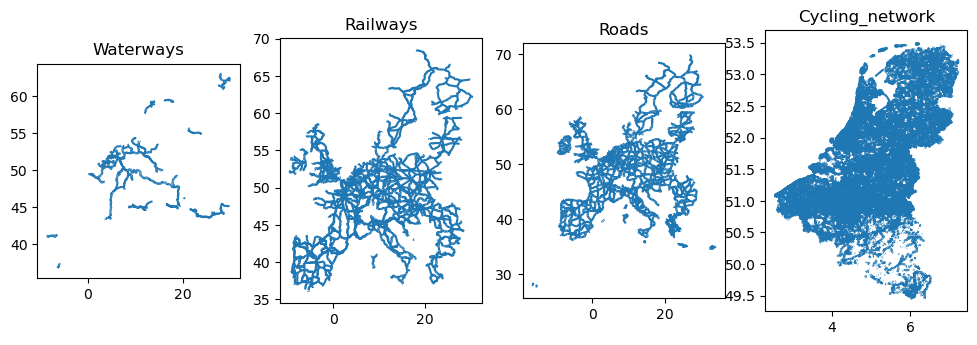

In [2]:
iww = gpd.read_file("data/TEN-T/iww_GL2017_EU_UK.shp")
railways = gpd.read_file("data/TEN-T/railways_GL2017_EU_UK.shp")
roads = gpd.read_file("data/TEN-T/roads_GL2017_EU_UK.shp")
cycling_network = gpd.read_file("data/cycle_network_all.gpkg")
iww.to_crs(4326,inplace=True),railways.to_crs(4326,inplace=True)
roads.to_crs(4326,inplace=True),cycling_network.to_crs(4326,inplace=True)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))
ax0.set_title('Waterways'),ax1.set_title('Railways'), ax2.set_title('Roads'),ax3.set_title('Cycling_network')
iww.plot(ax=ax0), railways.plot(ax=ax1), roads.plot(ax=ax2), cycling_network.plot(ax=ax3)

### Let's clip the iww, rail and road maps to the dimensions of the cycling network we have. We use the country code columns to filter the datasets:

(<Axes: title={'center': 'Roads'}>,
 <Axes: title={'center': 'Cycling_network'}>)

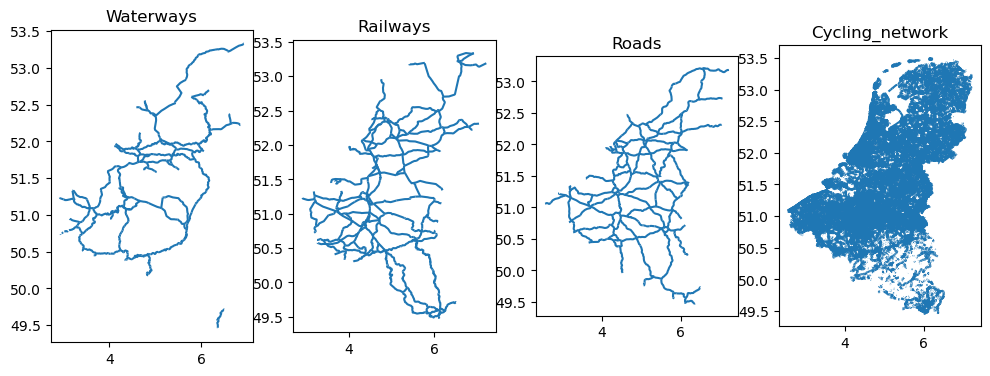

In [3]:
iww_benelux = iww.loc[iww["COUNTRY_CO"].isin(["BE","NL","LU"])]
railways_benelux = railways.loc[railways["COUNTRY_CO"].isin(["BE","NL","LU"])]
roads_benelux = roads.loc[roads["COUNTRY_CO"].isin(["BE","NL","LU"])]

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))
ax0.set_title('Waterways'),ax1.set_title('Railways'), ax2.set_title('Roads'),ax3.set_title('Cycling_network')
iww_benelux.plot(ax=ax0), railways_benelux.plot(ax=ax1)
roads_benelux.plot(ax=ax2), cycling_network.plot(ax=ax3)

## Preprocessing data
### Loading population density

<Axes: >

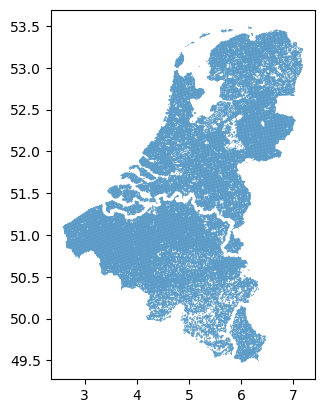

In [4]:
population_density = gpd.read_file("data\population_density\JRC_GRID_2018\JRC_POPULATION_2018.gpkg")
population_density.to_crs(4326,inplace=True)
population_density_benelux = population_density.loc[population_density["CNTR_ID"].isin(["BE","NL","LU"])]
population_density_benelux.plot()

### Calculating intersections
Intersections between each type of infrastructure and cycling network will return the current crossings

(<Axes: title={'center': 'Road crossings'}>,
 <Axes: title={'center': 'Road crossings'}>)

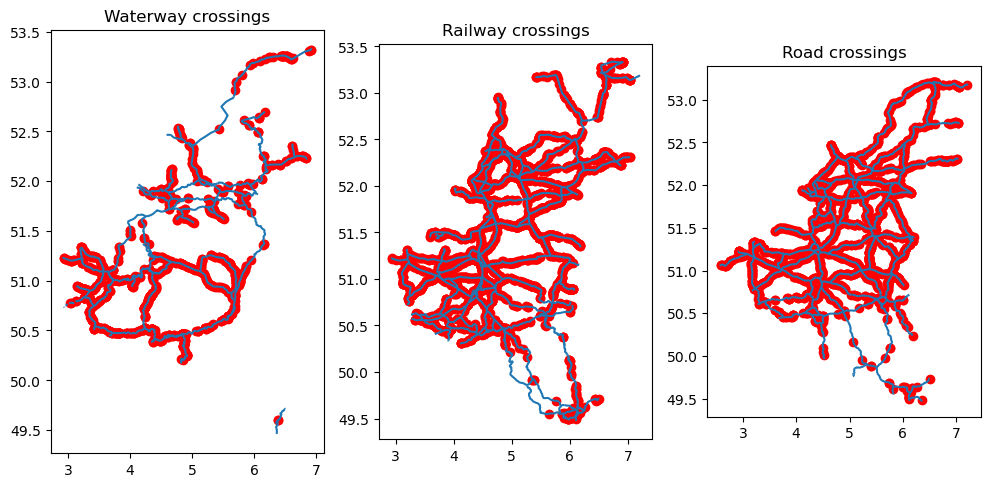

In [34]:
iww_crossings = iww_benelux.overlay(cycling_network,how="intersection",keep_geom_type=False)
railway_crossings = railways_benelux.overlay(cycling_network,how="intersection",keep_geom_type=False)
road_crossings = roads_benelux.overlay(cycling_network,how="intersection",keep_geom_type=False)

fig, (ax0,ax1,ax2) = plt.subplots(nrows=1,ncols=3,figsize=(12,6))
ax0.set_title('Waterway crossings'),ax1.set_title('Railway crossings'), ax2.set_title('Road crossings')
iww_benelux.plot(ax=ax0), iww_crossings.plot(ax=ax0,color="red")
railways_benelux.plot(ax=ax1), railway_crossings.plot(ax=ax1,color="red")
roads_benelux.plot(ax=ax2), road_crossings.plot(ax=ax2,color="red")

In [35]:
# Calculate distances function
from shapely.geometry import Point, LineString
def line_min_distance(line, points):
    distances = [line.distance(point) for point in points]
    distances = [distance for distance in distances if distance != 0] # Exclude distance to self
    return min(distances)

In [36]:
#Join crossings with population density - iww
iww_crossings = iww_crossings[iww_crossings.geom_type == "Point"]
iww_crossings = iww_crossings[["geometry"]]
iww_crossings.reset_index(drop=True, inplace=True)

iww_crossings = gpd.sjoin(iww_crossings,population_density_benelux,how="left",predicate="within")
iww_crossings = iww_crossings[["geometry","TOT_P_2018"]]
iww_crossings

crossings = iww_crossings["geometry"].explode()
coords = [point.coords[0] for point in crossings.geometry]
points = [Point(x, y) for x, y in coords]
distances = crossings.geometry.apply(lambda line: line_min_distance(line, points))
distances.rename("distance",inplace=True)
distances.reset_index(drop=True,inplace=True)
iww_crossings = pd.concat([iww_crossings,distances],axis=1)
iww_crossings["TOT_P_2018"].fillna(iww_crossings["TOT_P_2018"].mean(),inplace=True)
iww_crossings["TOT_P_2018"] = iww_crossings["TOT_P_2018"]/iww_crossings["TOT_P_2018"].max()
iww_crossings["distance"] = iww_crossings["distance"]/iww_crossings["distance"].max()
iww_crossings["weighted_distance"] = iww_crossings["TOT_P_2018"]*iww_crossings["distance"]
iww_crossings["weighted_distance"] = iww_crossings["weighted_distance"]/iww_crossings["weighted_distance"].max()
iww_crossings.head()

C:\Users\sedat\AppData\Local\Temp\ipykernel_20208\1139108646.py:10: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  crossings = iww_crossings["geometry"].explode()


geometry  TOT_P_2018  distance  weighted_distance
0  POINT (4.83720 50.46680)    0.137393  0.010195           0.037837
1  POINT (4.83365 50.46385)    0.137393  0.000900           0.003341
2  POINT (4.83390 50.46413)    0.137393  0.000900           0.003341
3  POINT (4.83254 50.46002)    0.158530  0.009580           0.041025
4  POINT (5.51562 51.61646)    0.000727  0.104414           0.002050

In [37]:
#Join crossings with population density - rail
railway_crossings = railway_crossings[railway_crossings.geom_type == "Point"]
railway_crossings = railway_crossings[["geometry"]]
railway_crossings.reset_index(drop=True, inplace=True)

railway_crossings = gpd.sjoin(railway_crossings,population_density_benelux,how="left",predicate="within")
railway_crossings = railway_crossings[["geometry","TOT_P_2018"]]
railway_crossings

crossings = railway_crossings["geometry"].explode()
coords = [point.coords[0] for point in crossings.geometry]
points = [Point(x, y) for x, y in coords]
distances = crossings.geometry.apply(lambda line: line_min_distance(line, points))
distances.rename("distance",inplace=True)
distances.reset_index(drop=True,inplace=True)
railway_crossings = pd.concat([railway_crossings,distances],axis=1)
railway_crossings["TOT_P_2018"].fillna(railway_crossings["TOT_P_2018"].mean(),inplace=True)
railway_crossings["TOT_P_2018"] = railway_crossings["TOT_P_2018"]/railway_crossings["TOT_P_2018"].max()
railway_crossings["distance"] = railway_crossings["distance"]/railway_crossings["distance"].max()
railway_crossings["weighted_distance"] = railway_crossings["TOT_P_2018"]*railway_crossings["distance"]
railway_crossings["weighted_distance"] = railway_crossings["weighted_distance"]/railway_crossings["weighted_distance"].max()
railway_crossings.head()

C:\Users\sedat\AppData\Local\Temp\ipykernel_20208\3832686820.py:10: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  crossings = railway_crossings["geometry"].explode()


geometry  TOT_P_2018  distance  weighted_distance
0  POINT (4.85201 50.81375)    0.002650  0.144917           0.005274
1  POINT (4.90685 50.78587)    0.002685  0.026007           0.000959
2  POINT (4.90685 50.78587)    0.002685  0.026007           0.000959
3  POINT (4.88747 50.79564)    0.108093  0.079372           0.117812
4  POINT (4.88747 50.79564)    0.108093  0.079372           0.117812

In [38]:
#Join crossings with population density - road
road_crossings = road_crossings[road_crossings.geom_type == "Point"]
road_crossings = road_crossings[["geometry"]]
road_crossings.reset_index(drop=True, inplace=True)

road_crossings = gpd.sjoin(road_crossings,population_density_benelux,how="left",predicate="within")
road_crossings = road_crossings[["geometry","TOT_P_2018"]]
road_crossings

crossings = road_crossings["geometry"].explode()
coords = [point.coords[0] for point in crossings.geometry]
points = [Point(x, y) for x, y in coords]
distances = crossings.geometry.apply(lambda line: line_min_distance(line, points))
distances.rename("distance",inplace=True)
distances.reset_index(drop=True,inplace=True)
road_crossings = pd.concat([road_crossings,distances],axis=1)
road_crossings["TOT_P_2018"].fillna(road_crossings["TOT_P_2018"].mean(),inplace=True)
road_crossings["TOT_P_2018"] = road_crossings["TOT_P_2018"]/road_crossings["TOT_P_2018"].max()
road_crossings["distance"] = road_crossings["distance"]/road_crossings["distance"].max()
road_crossings["weighted_distance"] = road_crossings["TOT_P_2018"]*road_crossings["distance"]
road_crossings["weighted_distance"] = road_crossings["weighted_distance"]/road_crossings["weighted_distance"].max()
road_crossings.head()

C:\Users\sedat\AppData\Local\Temp\ipykernel_20208\2038627466.py:10: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  crossings = road_crossings["geometry"].explode()


geometry  TOT_P_2018  distance  weighted_distance
0  POINT (4.44198 51.86635)    0.009706  0.018653           0.001766
1  POINT (4.43708 51.86732)    0.009706  0.018653           0.001766
2  POINT (4.50376 51.86336)    0.082423  0.023985           0.019286
3  POINT (4.49735 51.86309)    0.082423  0.023985           0.019286
4  POINT (4.48117 51.86131)    0.371512  0.002116           0.007669

In [39]:
all_crossings = pd.concat([iww_crossings,railway_crossings,road_crossings])
all_crossings.reset_index(drop=True, inplace=True)
all_crossings

geometry  TOT_P_2018  distance  weighted_distance
0     POINT (4.83720 50.46680)    0.137393  0.010195           0.037837
1     POINT (4.83365 50.46385)    0.137393  0.000900           0.003341
2     POINT (4.83390 50.46413)    0.137393  0.000900           0.003341
3     POINT (4.83254 50.46002)    0.158530  0.009580           0.041025
4     POINT (5.51562 51.61646)    0.000727  0.104414           0.002050
...                        ...         ...       ...                ...
7481  POINT (3.74601 51.02899)    0.087357  0.000582           0.000496
7482  POINT (3.74714 51.02964)    0.087357  0.004882           0.004160
7483  POINT (3.73378 51.02166)    0.103292  0.034530           0.034795
7484  POINT (3.72791 51.01321)    0.103292  0.003917           0.003947
7485  POINT (3.72851 51.01407)    0.103292  0.003917           0.003947

[7486 rows x 4 columns]

In [49]:
m = all_crossings.explore(column="weighted_distance",scheme='NaturalBreaks',cmap="viridis_r",vmin=0,vmax=1,marker_kwds=dict(radius=5, fill=True))
iww_benelux.explore(m=m,color="blue")
railways_benelux.explore(m=m,color="red")
roads_benelux.explore(m=m,color="green")
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>Rail</li>
    <li><span style='background:blue;opacity:0.7;'></span>IWW</li>
    <li><span style='background:green;opacity:0.7;'></span>Road</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

In [43]:
m.save("interactive_map.html")